# Install Library
This code snippet is setting up a Python environment in Google Colab for image processing and deep learning, focusing on the specific task of clothes segmentation. Let's break down each line:

![Sample Library Image](https://github.com/banyapon/pyhelper/blob/master/result.jpg?raw=true)

In [ ]:
import numpy as np
import cv2
import torch
import albumentations as albu
from pylab import imshow
from google.colab import files
from google.colab import drive
!pip install git+https://github.com/banyapon/pyhelper
!pip install git+https://github.com/banyapon/cloths_segmentation > /dev/null
%matplotlib inline
drive.mount('/content/gdrive')

# Upload Image
This section of the provided code is designed to create a folder named "clothImage" in your Google Drive and upload one image file to it.

In [ ]:
!mkdir "/content/gdrive/My Drive/clothImage"
img = files.upload()
keys = list(img)
allowefileformats = ['jpg','png','bmp','jpeg']
if len(img)!=1:
  print('Please Select only one image file')

elif keys[0].split('.')[-1] not in allowefileformats:
  print('Please select an image in formats: ',allowefileformats)

img_data = img[keys[-1]]
img_path = 'gdrive/My Drive/clothImage/'+keys[-1]
with open(img_path,'wb') as f:
  f.write(img_data)

Key Points

* **Pre-trained Model**: This code leverages a pre-trained model, which means you don't need to train the model from scratch. You can immediately use it for inference (making predictions).
* **Image Segmentation**: The primary goal is to identify and segment different clothing items within an image.
* **Custom Library**: The functions from iglovikov_helper_functions seem to be part of a custom or external library designed to simplify common tasks in deep learning projects.

In [ ]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from cloths_segmentation.pre_trained_models import create_model
model = create_model("Unet_2020-10-30")
model.eval();

# Segmentation and Analysis Process

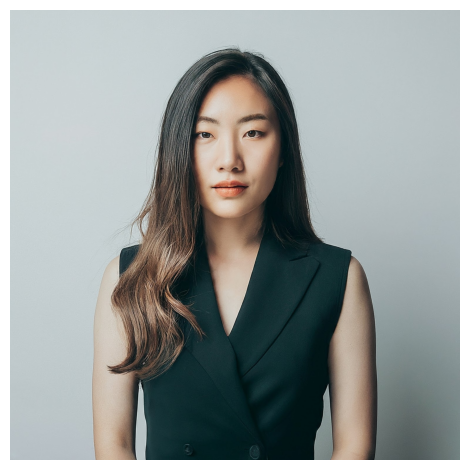

In [11]:
import matplotlib.pyplot as plt
image = load_rgb(img_path)
imshow(image)
dpi = plt.rcParams["figure.dpi"]
plt.axis('off')
plt.tight_layout()
plt.savefig('gdrive/My Drive/clothImage/target.jpg', dpi=dpi)

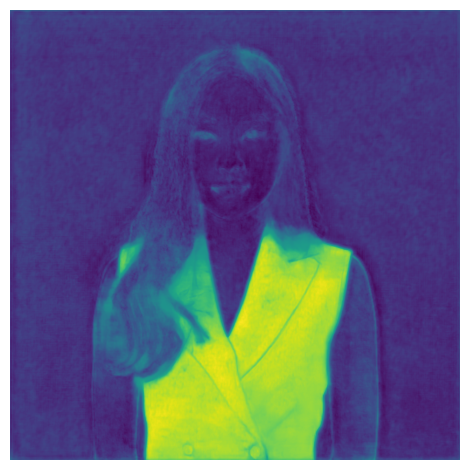

In [13]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
with torch.no_grad():
  prediction = model(x)[0][0]
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)
prediction = unpad(prediction, pads)
imshow(prediction)
dpi = plt.rcParams["figure.dpi"]
plt.axis('off')
plt.tight_layout()
plt.savefig('gdrive/My Drive/clothImage/prediction.jpg')

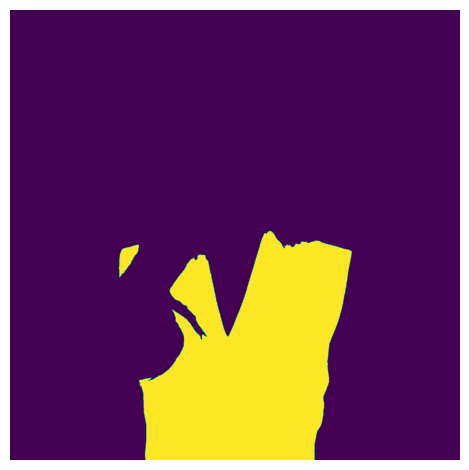

In [14]:
imshow(mask)
dpi = plt.rcParams["figure.dpi"]
plt.axis('off')
plt.tight_layout()
plt.savefig('gdrive/My Drive/clothImage/mask.png')

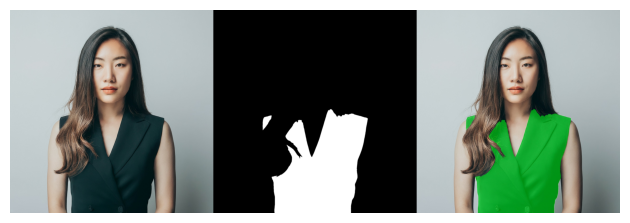

In [15]:
dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)
imshow(np.hstack([image, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255, dst]))
dpi = plt.rcParams["figure.dpi"]
plt.axis('off')
plt.tight_layout()
plt.savefig('gdrive/My Drive/clothImage/result.jpg')

In [16]:
# Load the mask image
mask_image = cv2.imread('gdrive/My Drive/clothImage/mask.png', cv2.IMREAD_GRAYSCALE)
# Save the black and white mask as a JPEG
cv2.imwrite('gdrive/My Drive/clothImage/mask.jpg', mask_image)

True

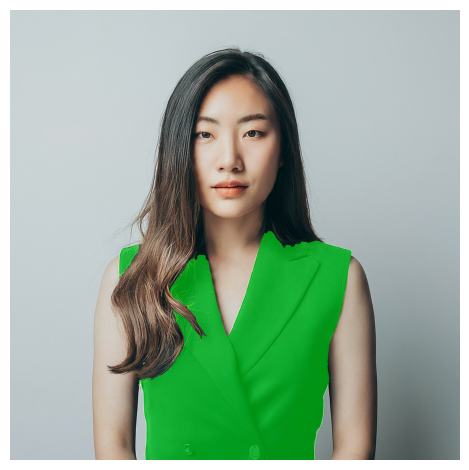

In [17]:
imshow(dst)
dpi = plt.rcParams["figure.dpi"]
plt.axis('off')
plt.tight_layout()
plt.savefig('gdrive/My Drive/clothImage/complete.jpg')

# Inpainting

Use the Diffusers Pipeline

In [ ]:
!pip install diffusers transformers

In [19]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

Load "RunwayML" Model

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
#pipe = pipe.to("cuda") #ถ้ามี GPU นะ

In [ ]:
# โหลดรูปภาพและ mask
image = Image.open("gdrive/My Drive/clothImage/target.jpg")
mask_image = Image.open("gdrive/My Drive/clothImage/mask.jpg")

# Resize mask to match image
mask_image = mask_image.resize(image.size)

# รัน Inpainting
prompt = "Chinese Red and Golder Armor"
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

# แสดงผลลัพธ์
image.show()


  0%|          | 0/50 [00:00<?, ?it/s]

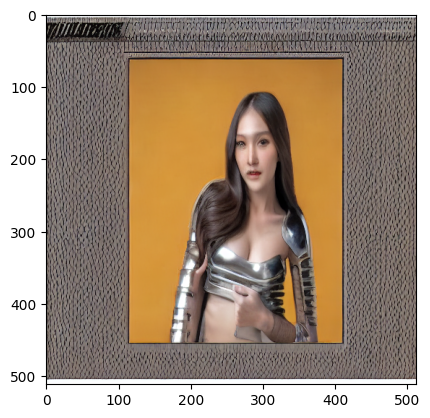

In [ ]:
imshow(image)
plt.savefig('gdrive/My Drive/clothImage/inpainting.jpg')